# Feature importance check

In [2]:

from src.util import read_results, train_test_validate_split, ExplodeColumns, model_operators, eval_result
import numpy as np 
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
# plt.style.use("/home/pepijn/Documents/uni/y5/thesis/writing/msc-thesis-figures/std-colors.mplstyle")

%load_ext autoreload
%autoreload 2

In [3]:
result_df = read_results(from_parquet=True)
result_df.columns
result_df = result_df.drop(columns=['features'])

In [4]:
list_features = [x for x in result_df.columns if result_df[x].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
result_df = ExplodeColumns(columns=list_features, max_len=5).transform(result_df)

Expanding columns: 100%|██████████| 6/6 [05:04<00:00, 50.75s/it]


In [5]:
categorical_columns = result_df.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping {categorical_columns}")
for col in categorical_columns:
    result_df[col] = result_df[col].astype('category')

Dropping ['dataset', 'operator', 'join', 'compute_unit', 'source_file', 'dataset_type', 'compute_type', 'gpu__architecture']


In [6]:
target_cols = ['speedup', 'times_mean', 'label', 'time_saved', 'materialized_times_mean']

def split_data(df, target_cols):
    X = df.drop(columns=target_cols)
    y = df[target_cols]
    return X, y

train, test, validate = train_test_validate_split(result_df)
X_train, y_train = split_data(train, target_cols)
X_test, y_test = split_data(test, target_cols)
X_validate, y_validate = split_data(validate, target_cols)


train set:
	Records: 189256
	Positive (speedup > 1 with factorizing)/Negative: 36554/152702 = 0.24 s
	Dataset types: ['synthetic']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['v100', '2080', 'CPU 16c', 'a40', 'CPU 08c', '1080', 'CPU 32c']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
test set:
	Records: 81110
	Positive (speedup > 1 with factorizing)/Negative: 15420/65690 = 0.23 s
	Dataset types: ['synthetic']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['2080', 'CPU 08c', 'CPU 32c', 'a40', 'v100', 'CPU 16c', '1080']
Categories (8, object): ['1080', '2080', 'CPU 08c', 'CPU 16c', 'CPU 32c', 'a40', 'p100', 'v100']
validate set:
	Records: 42183
	Positive (speedup > 1 with factorizing)/Negative: 5569/36614 = 0.15 s
	Dataset types: ['synthetic', 'hamlet', 'tpc_ai']
Categories (3, object): ['hamlet', 'synthetic', 'tpc_ai']
\Compute Units: ['p100', 'CPU 32c', 'CPU 16c', 'CPU 08c', '2

In [7]:
cols = result_df.head(1).T

In [8]:
from sklearn.metrics import mean_squared_error
import seaborn as sns


def plot_boundary(y_true, y_pred, lower=-1.0, upper=1.0, step=0.1, target_col=None, full_dataset=None, ax=None):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x = np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred=y_pred > boundary, full_dataset=full_dataset, target_col=target_col)
        results.append({"boundary": boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax = sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label="time_saved", ax=ax)
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label="speedup", color="orange")
    ax.grid()
    ax.legend(loc="lower right")
    ax.set_title(f"Boundary vs. Time saved {target_col}")
    return ax


def train_and_eval(name, X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=False, estimator_kwargs={}):
    model_operators_mask_test = X_test["operator"].isin(model_operators)
    X_test = X_test.loc[model_operators_mask_test]
    y_test = y_test.loc[model_operators_mask_test]

    model_operators_mask_validate = X_validate["operator"].isin(model_operators)
    X_validate = X_validate[model_operators_mask_validate]
    y_validate = y_validate.loc[model_operators_mask_validate]
    df_filtered = result_df[result_df["operator"].isin(model_operators)]
    if only_model:
        # Filter the datasets based on the condition
        model_operators_mask_train = X_train["operator"].isin(model_operators)
        X_train = X_train[model_operators_mask_train]
        y_train = y_train.loc[model_operators_mask_train]
    else:
        df_filtered = result_df

    clf = xgboost.XGBRegressor(enable_categorical=True, **estimator_kwargs)
    clf.fit(X_train, y_train[target_col])
    display(pd.DataFrame(zip(X_train.columns, clf.feature_importances_)).sort_values(1, ascending=False).head(10))

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for X, y, dataset_name, ax in zip(
        [X_train, X_test, X_validate], [y_train, y_test, y_validate], ["train", "test", "validate"], axs
    ):
        plt.sca(ax)
        y_true = y[target_col]
        y_pred = clf.predict(X)
        print(dataset_name, mean_squared_error(y_true, y_pred))

        if isinstance(target_col, list):
            print("Assuming target cols are materialized_times_mean and times_mean")
            pred = pd.DataFrame(y_pred, index=y_true.index)
            pred.columns = y_true.columns
            y_pred = pred["materialized_times_mean"] - pred["times_mean"]
            y_true = y_true["materialized_times_mean"] - y_true["times_mean"]
            eval_target_col = 'time_saved'
        else:
            eval_target_col = target_col

        lower, upper = (0.8, 2.0) if target_col == "speedup" else (-1.0, 1.0)
        ax = plot_boundary(y_true, y_pred, lower,upper, target_col=eval_target_col, full_dataset=df_filtered.loc[y_true.index],ax=ax)
        xgb_results[(name, dataset_name)] = eval_result(
            y_true,
            y_pred,
            full_dataset=df_filtered.loc[y_true.index],
            model_name=f"{name}: {dataset_name}",
            target_col=eval_target_col,
            plot=True,
        )[0]
    return clf

[(['times_mean', 'materialized_times_mean'], True),
 (['times_mean', 'materialized_times_mean'], False),
 ('speedup', True),
 ('speedup', False),
 ('time_saved', False),
 ('time_saved', True)]

,0,1
0,operator,0.297784
11,mem_fac_read,0.161797
1,num_cores,0.108569
38,comp_fac,0.070556
9,mem_mat_read,0.052675
3,cardinality_T,0.044081
21,comp_scalar_dense,0.035131
29,mem_read_rowsum,0.027684
14,comp_lmm_mat,0.026960
10,mem_mat_write,0.026876


train 0.08118229387519746
Assuming target cols are materialized_times_mean and times_mean
test 0.20591739405597742
Assuming target cols are materialized_times_mean and times_mean
validate 18.048383629000224
Assuming target cols are materialized_times_mean and times_mean


,0,1
0,operator,0.265290
11,mem_fac_read,0.122950
1,num_cores,0.115704
21,comp_scalar_dense,0.107846
10,mem_mat_write,0.061667
9,mem_mat_read,0.060976
38,comp_fac,0.059693
3,cardinality_T,0.033089
14,comp_lmm_mat,0.024439
44,nnz_T,0.014467


train 0.02421185981491418
Assuming target cols are materialized_times_mean and times_mean
test 0.2082553524014627
Assuming target cols are materialized_times_mean and times_mean
validate 18.74331119693662
Assuming target cols are materialized_times_mean and times_mean


,0,1
37,comp_mat,0.149045
27,mem_read_matrix_dense,0.078466
0,operator,0.058910
39,comp_ratio,0.054045
1,num_cores,0.052143
44,nnz_T,0.051980
47,c_T,0.046415
21,comp_scalar_dense,0.042687
29,mem_read_rowsum,0.041590
10,mem_mat_write,0.030256


train 0.005889081010475013
test 0.02463442697291817
validate 2.588361523623165


,0,1
3,cardinality_T,0.184960
1,num_cores,0.107298
6,complexity_ratio,0.090563
0,operator,0.073685
43,FR,0.064931
44,nnz_T,0.050334
66,r_S_0,0.049608
47,c_T,0.046478
77,nnz_S_1,0.045974
81,sparsity_S_0,0.039387


train 3.1629225577384834
test 0.047714003469666554
validate 2.7166519718863316


,0,1
0,operator,0.356573
67,r_S_1,0.134407
1,num_cores,0.116260
11,mem_fac_read,0.063686
45,nnz_S_sum,0.044863
48,sparsity_T,0.041340
6,complexity_ratio,0.028523
39,comp_ratio,0.027370
5,join,0.026885
3,cardinality_T,0.026486


train 0.049828386374113104
test 0.3910132836017764
validate 9.180496982594056


,0,1
0,operator,0.293375
1,num_cores,0.130333
67,r_S_1,0.091177
11,mem_fac_read,0.090608
45,nnz_S_sum,0.061828
39,comp_ratio,0.046386
3,cardinality_T,0.035451
48,sparsity_T,0.033027
5,join,0.031463
6,complexity_ratio,0.026892


C:\Users\ptema\AppData\Local\Temp\ipykernel_24772\3486203211.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))


train 0.16238475499137914
test 0.39503419227284153
validate 9.9676974279522


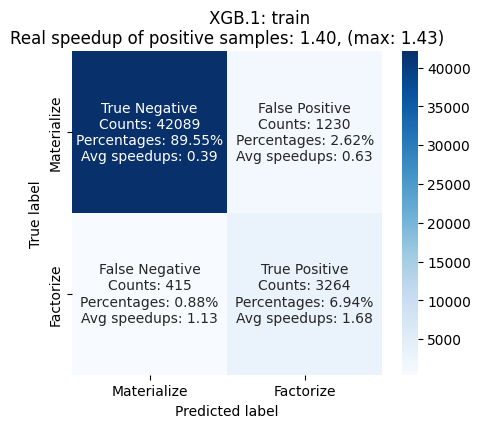

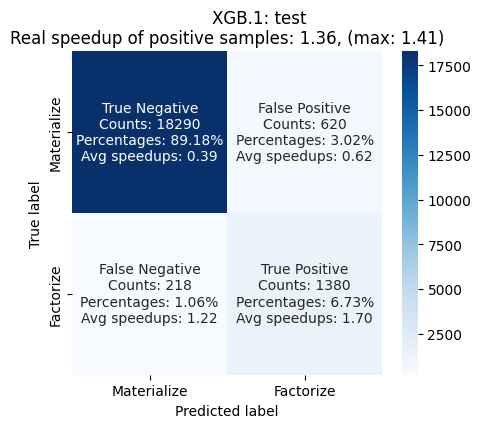

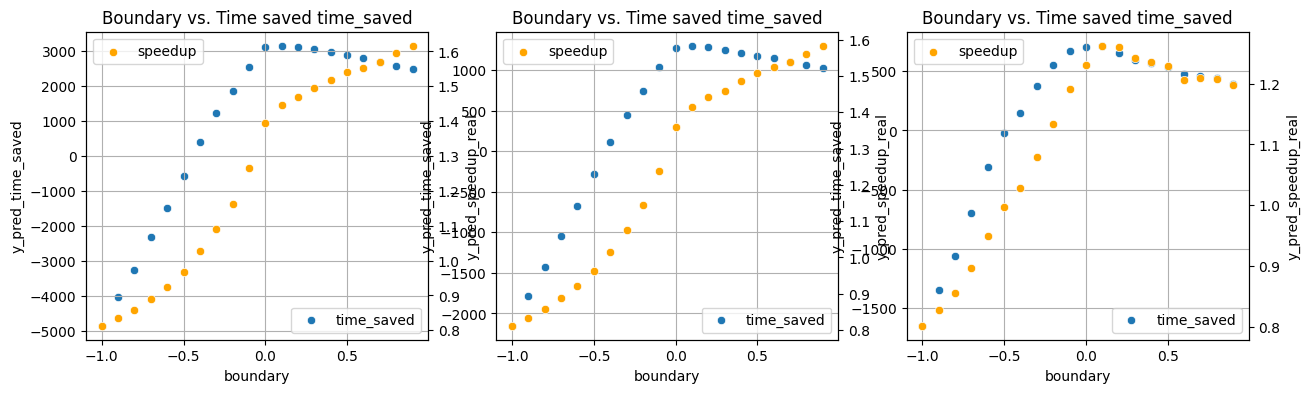

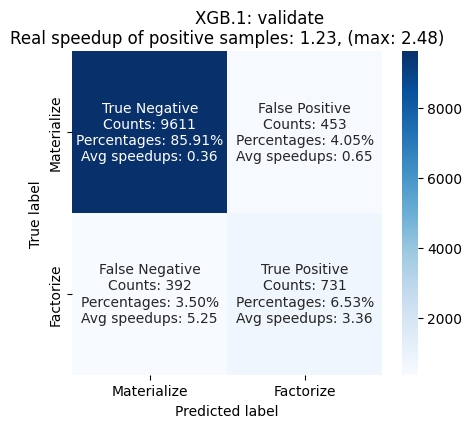

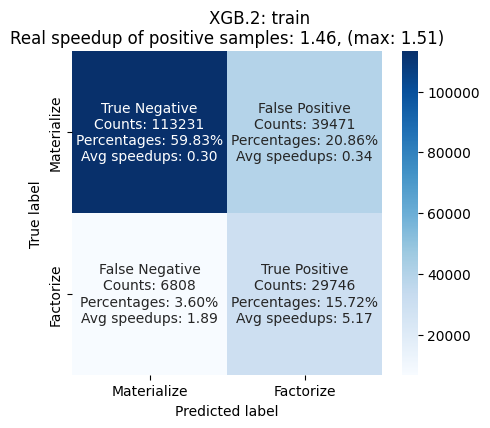

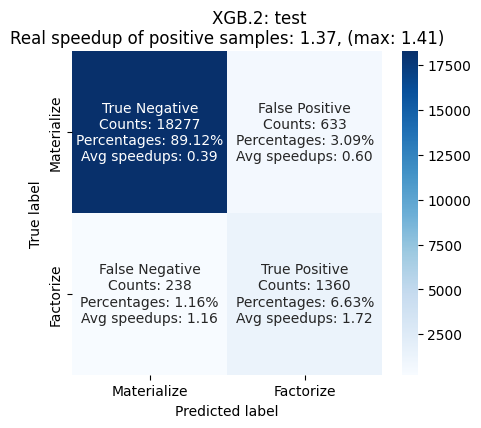

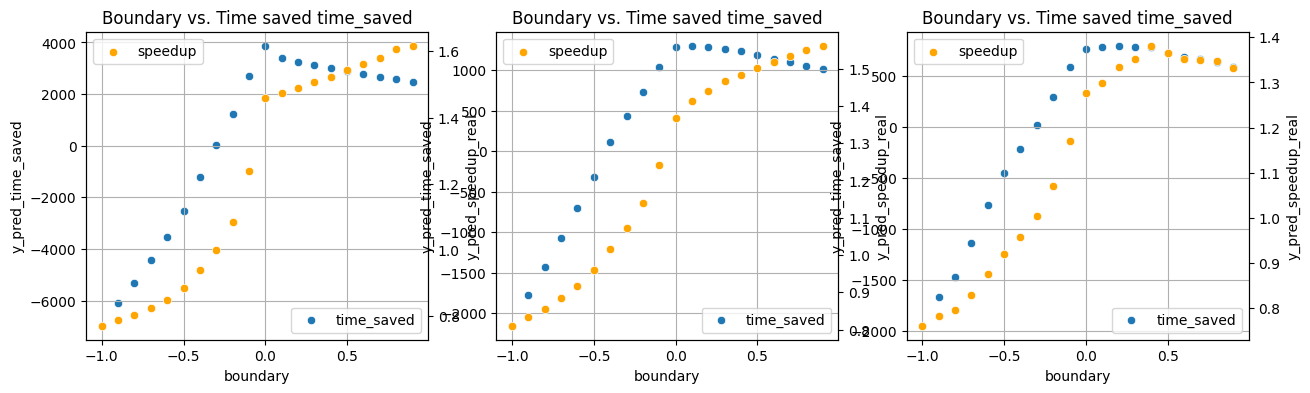

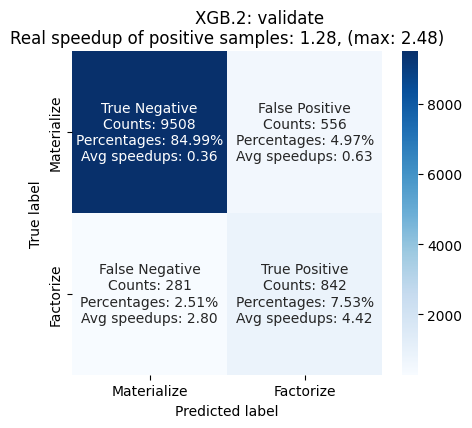

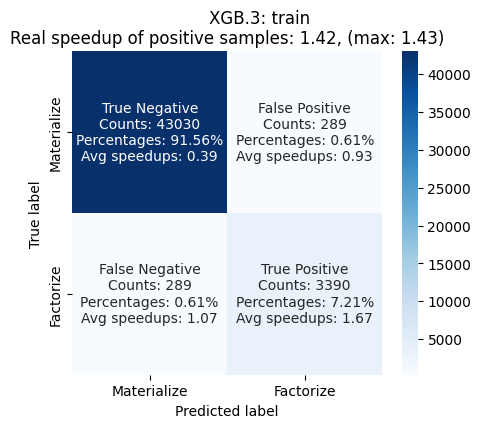

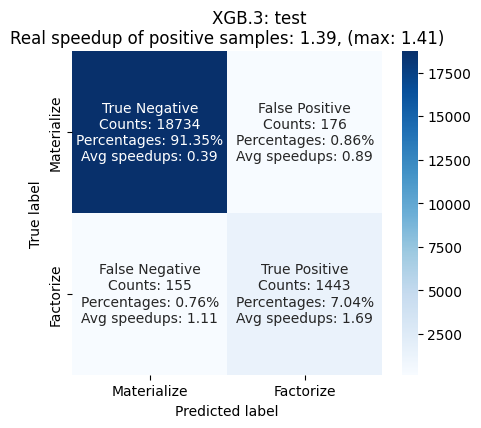

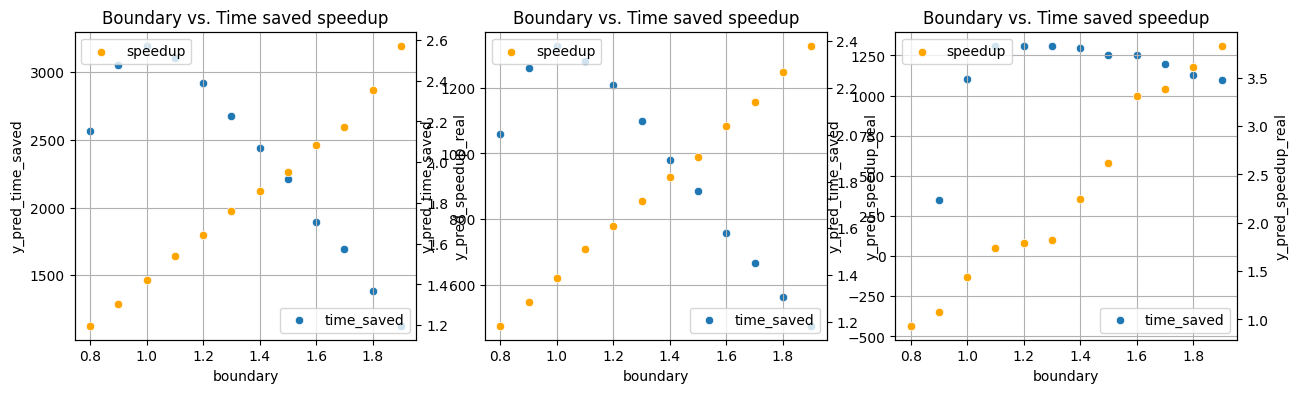

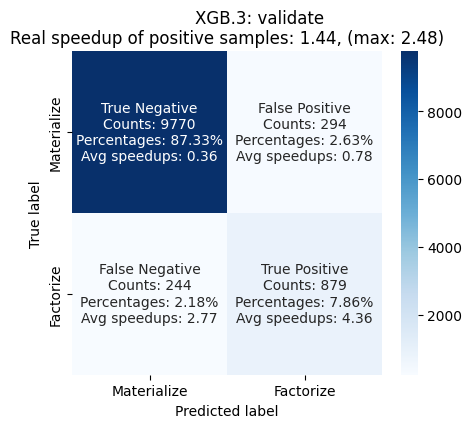

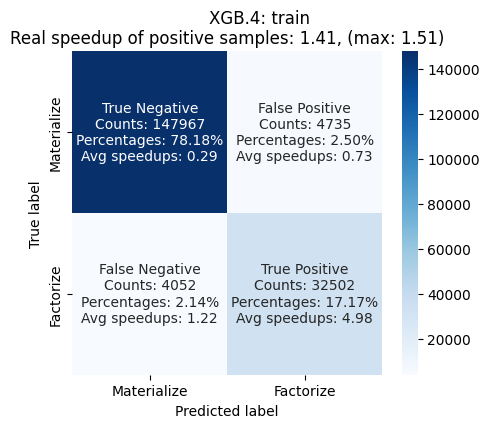

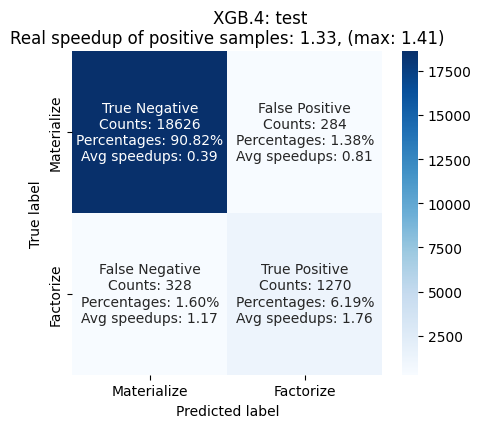

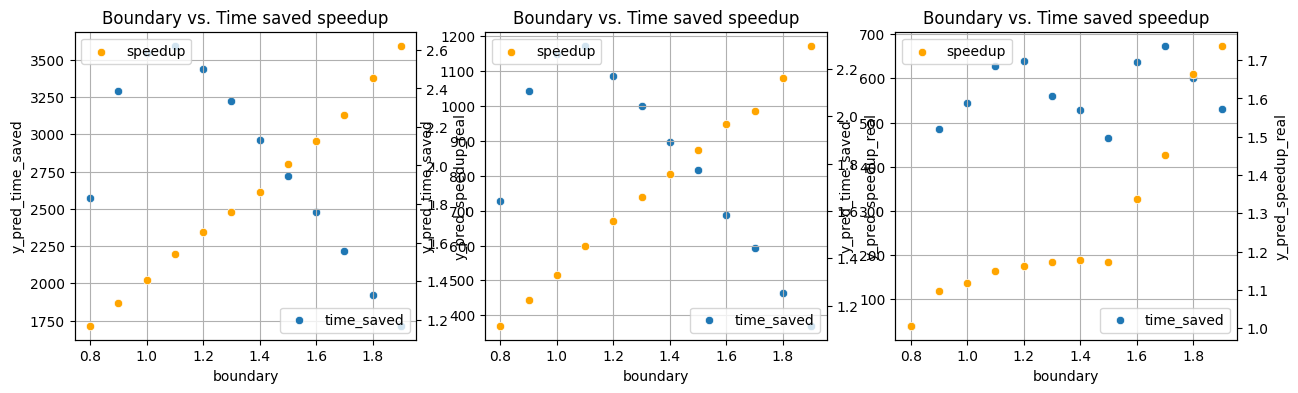

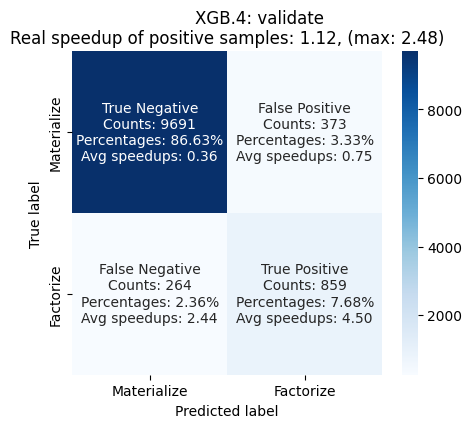

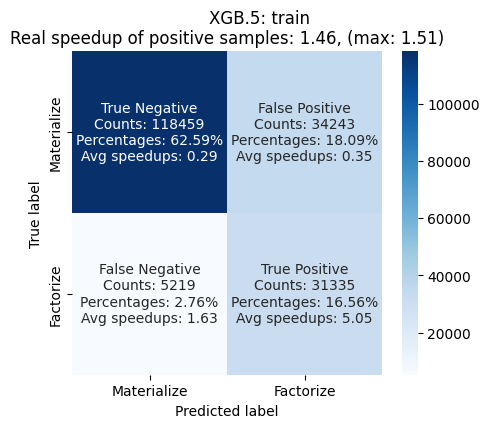

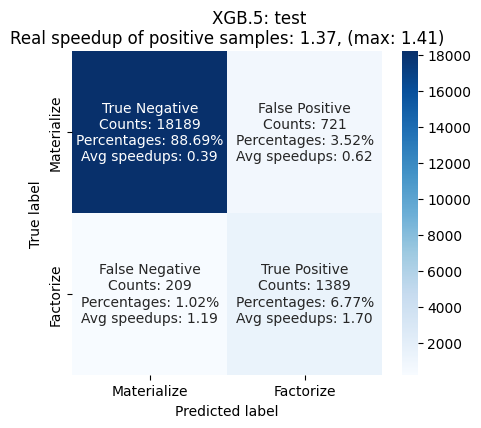

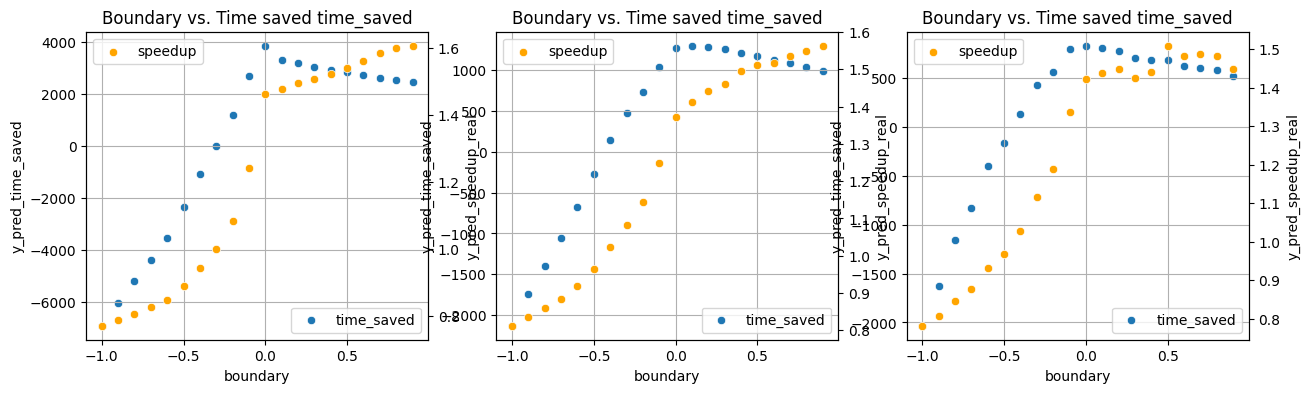

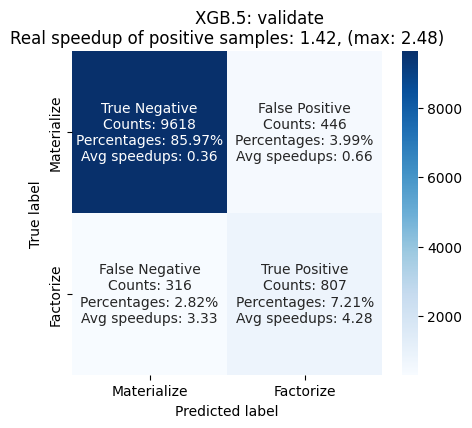

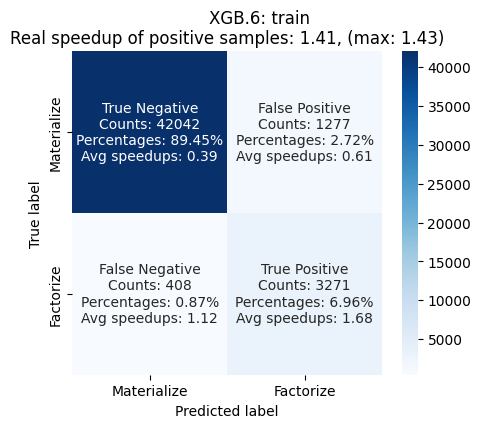

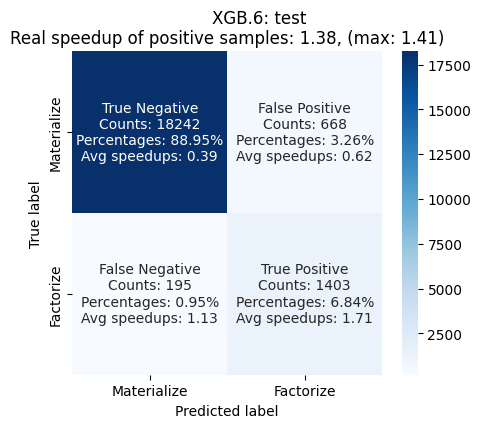

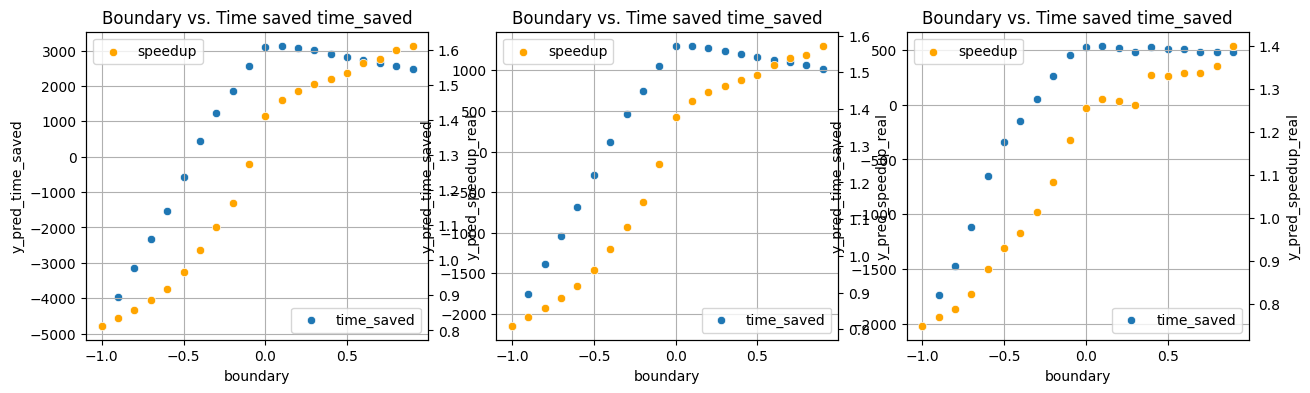

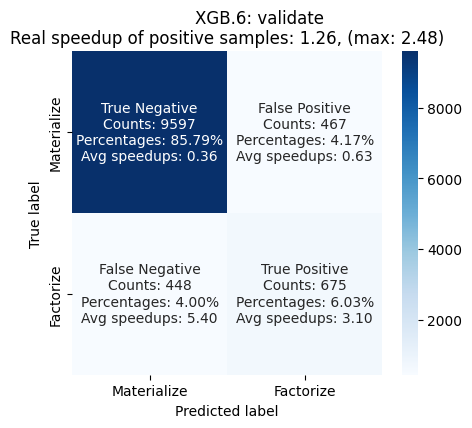

In [177]:
l= list(zip(["speedup", "time_saved", ["times_mean", "materialized_times_mean"]]*2, [True, False]*3))
l.sort(key=lambda x: str(x[0]))
display(l)
xgb_results = {}
xgb_estimators = {}
for i, (target_col, only_model) in enumerate(l):
    xgb_estimators[f"XGB.{i+1}"] = (target_col, only_model), train_and_eval(f"XGB.{i+1}",X_train, y_train, X_test, y_test, X_validate, y_validate, target_col, only_model=only_model)


In [178]:
import pickle
with open("trained_models/xgb3.pkl", "wb") as f:
    pickle.dump(xgb_estimators["XGB.3"][1], f)

In [11]:
xgb_results

{('XGB.1', 'train'): {'r2': 0.986561173523392,
  'mean_squared_error': 0.16024268439780567,
  'accuracy': 0.964998510574918,
  'precision': 0.7263017356475301,
  'recall': 0.8871976080456646,
  'f1': 0.7987275174354581,
  'speedup': {'y_true_mat_time': 10837.650210726451,
   'y_true_fact_time': 7571.225256854341,
   'y_true_best_time': 7571.225256854341,
   'y_true_time_saved': 3266.4249538721106,
   'y_true_speedup_avg': 1.6187113116647356,
   'y_true_speedup_real': 1.4314262015801165,
   'y_pred_mat_time': 10989.185142309962,
   'y_pred_fact_time': 7872.532530215499,
   'y_pred_best_time': 7760.608469586101,
   'y_pred_time_saved': 3116.6526120944627,
   'y_pred_speedup_avg': 1.3925179064516708,
   'y_pred_speedup_real': 1.3958894549031668,
   'TP': (3264, 1.6814503558653888),
   'FP': (1230, 0.625789845568438),
   'TN': (42089, 0.38851582201431817),
   'FN': (415, 1.1252649495660991)}},
 ('XGB.1', 'test'): {'r2': 0.9668865741085525,
  'mean_squared_error': 0.4094526404368964,
  'acc

In [34]:
resdf = pd.DataFrame(xgb_results.values())
resdf['Model'] = [x[0] for x in xgb_results.keys()]
resdf['dataset'] = [x[1] for x in xgb_results.keys()]
resdf['target'] = np.array([[str(x[0])] * 3 for x in l]).flatten()
resdf['target'] = resdf['target'].replace({"['times_mean', 'materialized_times_mean']": "time_saved"})
resdf['pruned'] = np.array([[x[1]] * 3 for x in l]).flatten()
resdf = resdf.merge(pd.json_normalize(resdf.speedup), left_index=True, right_index=True)
resdf['fraction_of_optimal_time_saved'] = resdf.y_pred_time_saved / resdf.y_true_time_saved
resdf

,r2,mean_squared_error,accuracy,precision,recall,f1,speedup,Model,dataset,target,...,y_pred_fact_time,y_pred_best_time,y_pred_time_saved,y_pred_speedup_avg,y_pred_speedup_real,TP,FP,TN,FN,fraction_of_optimal_time_saved
0,0.986561,0.160243,0.964999,0.726302,0.887198,0.798728,"{'y_true_mat_time': 10837.650210726451, 'y_tru...",XGB.1,train,time_saved,...,7872.532530,7760.608470,3116.652612,1.392518,1.395889,"(3264, 1.6814503558653888)","(1230, 0.625789845568438)","(42089, 0.38851582201431817)","(415, 1.1252649495660991)",0.954148
1,0.966887,0.409453,0.959138,0.690000,0.863579,0.767093,"{'y_true_mat_time': 4766.433451637602, 'y_true...",XGB.1,test,time_saved,...,3559.810719,3484.584445,1279.103061,1.365203,1.359318,"(1380, 1.7022080302986409)","(620, 0.6150957685015183)","(18290, 0.39060736553176856)","(218, 1.2240820350736383)",0.919154
2,0.636246,7.317649,0.924466,0.617399,0.650935,0.633723,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.1,validate,time_saved,...,3061.814555,2637.992986,704.454082,2.319170,1.230077,"(731, 3.3555380364151697)","(453, 0.6467979425329697)","(9611, 0.36385769878979485)","(392, 5.25015249442069)",0.422474
3,0.985875,0.047823,0.755469,0.429750,0.813755,0.562460,"{'y_true_mat_time': 12338.94996919519, 'y_true...",XGB.2,train,time_saved,...,8431.741214,8230.559041,3871.272056,2.416138,1.459131,"(29746, 5.172896385639828)","(39471, 0.3385995611364822)","(113231, 0.29669728235956283)","(6808, 1.8898504415830237)",0.928889
4,0.966497,0.414271,0.957529,0.682388,0.851064,0.757449,"{'y_true_mat_time': 4766.433451637602, 'y_true...",XGB.2,test,time_saved,...,3498.486494,3423.121844,1281.681061,1.365644,1.366353,"(1360, 1.7202275751494263)","(633, 0.6038208257038034)","(18277, 0.390838185116621)","(238, 1.1612918624157886)",0.921006
5,0.595957,8.128128,0.925181,0.602289,0.749777,0.667989,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.2,validate,time_saved,...,2786.334268,2374.769502,768.790211,2.914651,1.275915,"(842, 4.422168477190281)","(556, 0.6316826904750243)","(9508, 0.36167650769163234)","(281, 2.8024634328760953)",0.461058
6,0.971021,0.005889,0.987702,0.921446,0.921446,0.921446,"{'y_true_mat_time': 10837.650210726451, 'y_tru...",XGB.3,train,speedup,...,7574.377823,7537.488944,3193.767094,1.607489,1.421654,"(3390, 1.665524759628622)","(289, 0.9267222521030761)","(43030, 0.3916835048094824)","(289, 1.069584707520875)",0.977756
7,0.887289,0.024634,0.983860,0.891291,0.903004,0.897109,"{'y_true_mat_time': 4766.433451637602, 'y_true...",XGB.3,test,speedup,...,3409.811003,3381.708059,1328.090049,1.606371,1.389491,"(1443, 1.6933129880502125)","(176, 0.89354198998841)","(18734, 0.39331187689810126)","(155, 1.1125569271078748)",0.954355
8,0.218321,2.588362,0.951908,0.749361,0.782725,0.765679,"{'y_true_mat_time': 2792.661280960886, 'y_true...",XGB.3,validate,speedup,...,2489.837261,2093.608294,1103.188289,3.464619,1.443076,"(879, 4.361653952509765)","(294, 0.7826670358487708)","(9770, 0.3643737668880876)","(244, 2.774853517116049)",0.661603
9,0.778787,3.162923,0.953571,0.872842,0.889150,0.880920,"{'y_true_mat_time': 12338.94996919519, 'y_true...",XGB.4,train,speedup,...,8691.611174,8271.810519,3544.453745,4.437027,1.407802,"(32502, 4.977745491671789)","(4735, 0.7254276695058337)","(147967, 0.29415540790421946)","(4052, 1.222209704645377)",0.850471


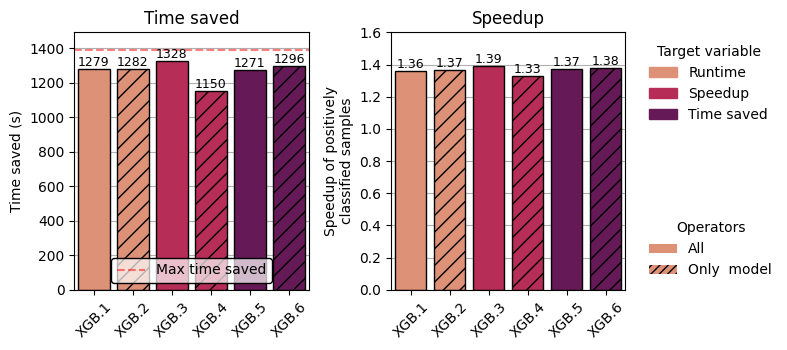

In [174]:
import matplotlib

pal = sns.color_palette("rocket_r", 3)[:3]
colors = [pal[0], pal[0], pal[1], pal[1], pal[2], pal[2]]
colors = [sns.set_hls_values(c, s=0.6) for c in colors]
hatches = ["", "//", "", "//", "", "//"]	

f, axs = plt.subplots(1, 2, figsize=(8, 0.45*8))
labels = ["Time saved (s)", "Speedup of positively\nclassified samples", "Fraction of best time saved"]
titles = ["Time saved", "Speedup", "Performance"]
max_time_saved = resdf[resdf.dataset=='test'].y_true_time_saved.max()

for ax, var, label, title in zip(axs, ["y_pred_time_saved", "y_pred_speedup_real", "fraction_of_optimal_time_saved"][:2], labels[:2], titles[:2]):
    sns.barplot(
        data=resdf[(resdf.dataset == "test")],
        x="Model",
        y=var,
        ax=ax,
        saturation=0.6,
        edgecolor="black",
        linewidth=1,
        palette=sns.color_palette("rocket_r"),
        # hue="target",
        # style='target'
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.set_ylabel(label)
    ax.set_xlabel("Target variable")
    ax.set_xlabel(None)
    ax.set_title(title)
    # ax.set_xticklabels(["XGB.1\nSpeedup", "XGB.2\nTime saved", "XGB.3 Time saved\n(separate F/M)"], rotation=45)
    fmt = ".2f"
    if var == "fraction_of_optimal_time_saved":
        # ax.set_ylim(0, 1)
        ...
    elif var == "y_pred_speedup_real":
        ax.set_ylim(top=1.6)
        ...
    elif var == "y_pred_time_saved":
        # ax.set_ylim(0, 1400)
        # ax.set_ylim(1000, max_time_saved+100)
        fmt = ".0f"
        ax.axhline(max_time_saved, color='red', linestyle='--', label="Max time saved", alpha=0.5)
        legend = ax.legend(loc='lower center', framealpha=0.8, fancybox=True)
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_facecolor((1, 1, 1, 0.7))
        ax.set_ylim(top=max_time_saved+100)
        
    for i, bar in enumerate(ax.patches):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), format(bar.get_height(), fmt), 
                ha='center', va='bottom', fontsize=9)
        bar.set_facecolor(colors[i])
        bar.set_hatch(hatches[i])

cs = {'Runtime':colors[0], 'Speedup':colors[2], 'Time saved':colors[4]}         
labels = list(cs.keys())
handles = [plt.Rectangle((0,0),1,1, color=cs[label]) for label in labels]  
l1 = axs[1].legend(handles, labels, loc='upper left', title="Target variable", bbox_to_anchor=(1.05, 1), frameon=False)
hatches = {'All': None, 'Only  model': r'////'}
handles = [matplotlib.patches.Patch(facecolor=colors[0], hatch=hatches[label]) for label in hatches.keys()]
l2 = axs[1].legend(handles, hatches.keys(), loc='lower left', title="Operators" , bbox_to_anchor=(1.05, 0), frameon=False)
axs[1].add_artist(l1)
# axs[1].add_artist(l2)
f.tight_layout()
f.savefig("./xgb-models-compare.pdf", bbox_inches='tight')

TypeError: 'NoneType' object is not callable

# Hyperparams

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# def time_saved(y_true, y_pred):
#     tot_time_pred = y_true[y_pred > 0].sum()
#     return tot_time_pred
       

# # Define the hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.5, 0.7, 1], 
#     "lambda": [0.5, 1, 2],
#     "alpha": [0.5, 1, 2],
# }

# # Create the XGBoost model object
# xgb_model = xgboost.XGBRegressor(enable_categorical=True)

# # Create the GridSearchCV object
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring={"time_saved": make_scorer(time_saved, greater_is_better=True),
#                                                                  "mse": "neg_mean_squared_error"}, refit="time_saved", verbose=3)

# target_col = 'time_saved'
# loc = X_train["operator"].isin(model_operators)
# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train.loc[loc], y_train.loc[loc][target_col])

# # Print the best set of hyperparameters and the corresponding score
# print("Best set of hyperparameters: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

In [ ]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, 'time_saved', only_model=True, estimator_kwargs={'alpha': 0.5, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})

In [ ]:
# train_and_eval(X_train, y_train, X_test, y_test, X_validate, y_validate, ['materialized_times_mean', 'times_mean'], only_model=True, estimator_kwargs={'alpha': 2, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7})